In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import evidential_deep_learning as edl
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2.8.1


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (727292, 6)


,turbine,V,theta,W,T,P
727287,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
727288,R80736,20.50,0.307352,1.799085,10837.3,2043120.0
727289,R80721,20.78,0.323933,1.799085,10850.1,2045870.0
727290,R80711,20.94,0.341386,1.799085,10853.8,2046570.0
727291,R80736,21.67,0.347670,1.798038,10871.8,2048260.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
727287,20.48,0.293564,1.801180,10817.3,2041980.0
727288,20.50,0.307352,1.799085,10837.3,2043120.0
727289,20.78,0.323933,1.799085,10850.1,2045870.0
727290,20.94,0.341386,1.799085,10853.8,2046570.0
727291,21.67,0.347670,1.798038,10871.8,2048260.0


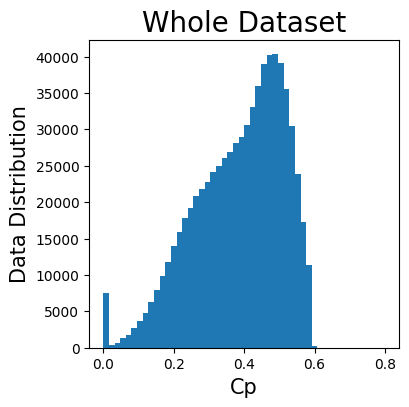

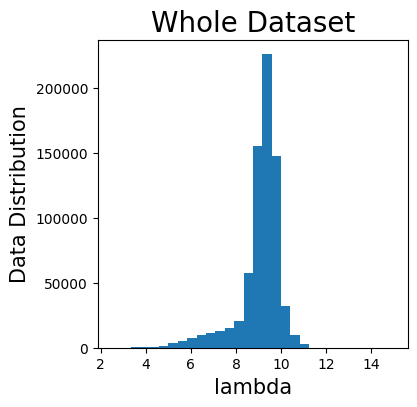

,V,theta,W,T,P,Cp,lambda
727287,20.48,0.293564,1.801180,10817.3,2041980.0,0.073492,3.605878
727288,20.50,0.307352,1.799085,10837.3,2043120.0,0.073318,3.598171
727289,20.78,0.323933,1.799085,10850.1,2045870.0,0.070489,3.549687
727290,20.94,0.341386,1.799085,10853.8,2046570.0,0.068909,3.522565
727291,21.67,0.347670,1.798038,10871.8,2048260.0,0.062228,3.401918


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

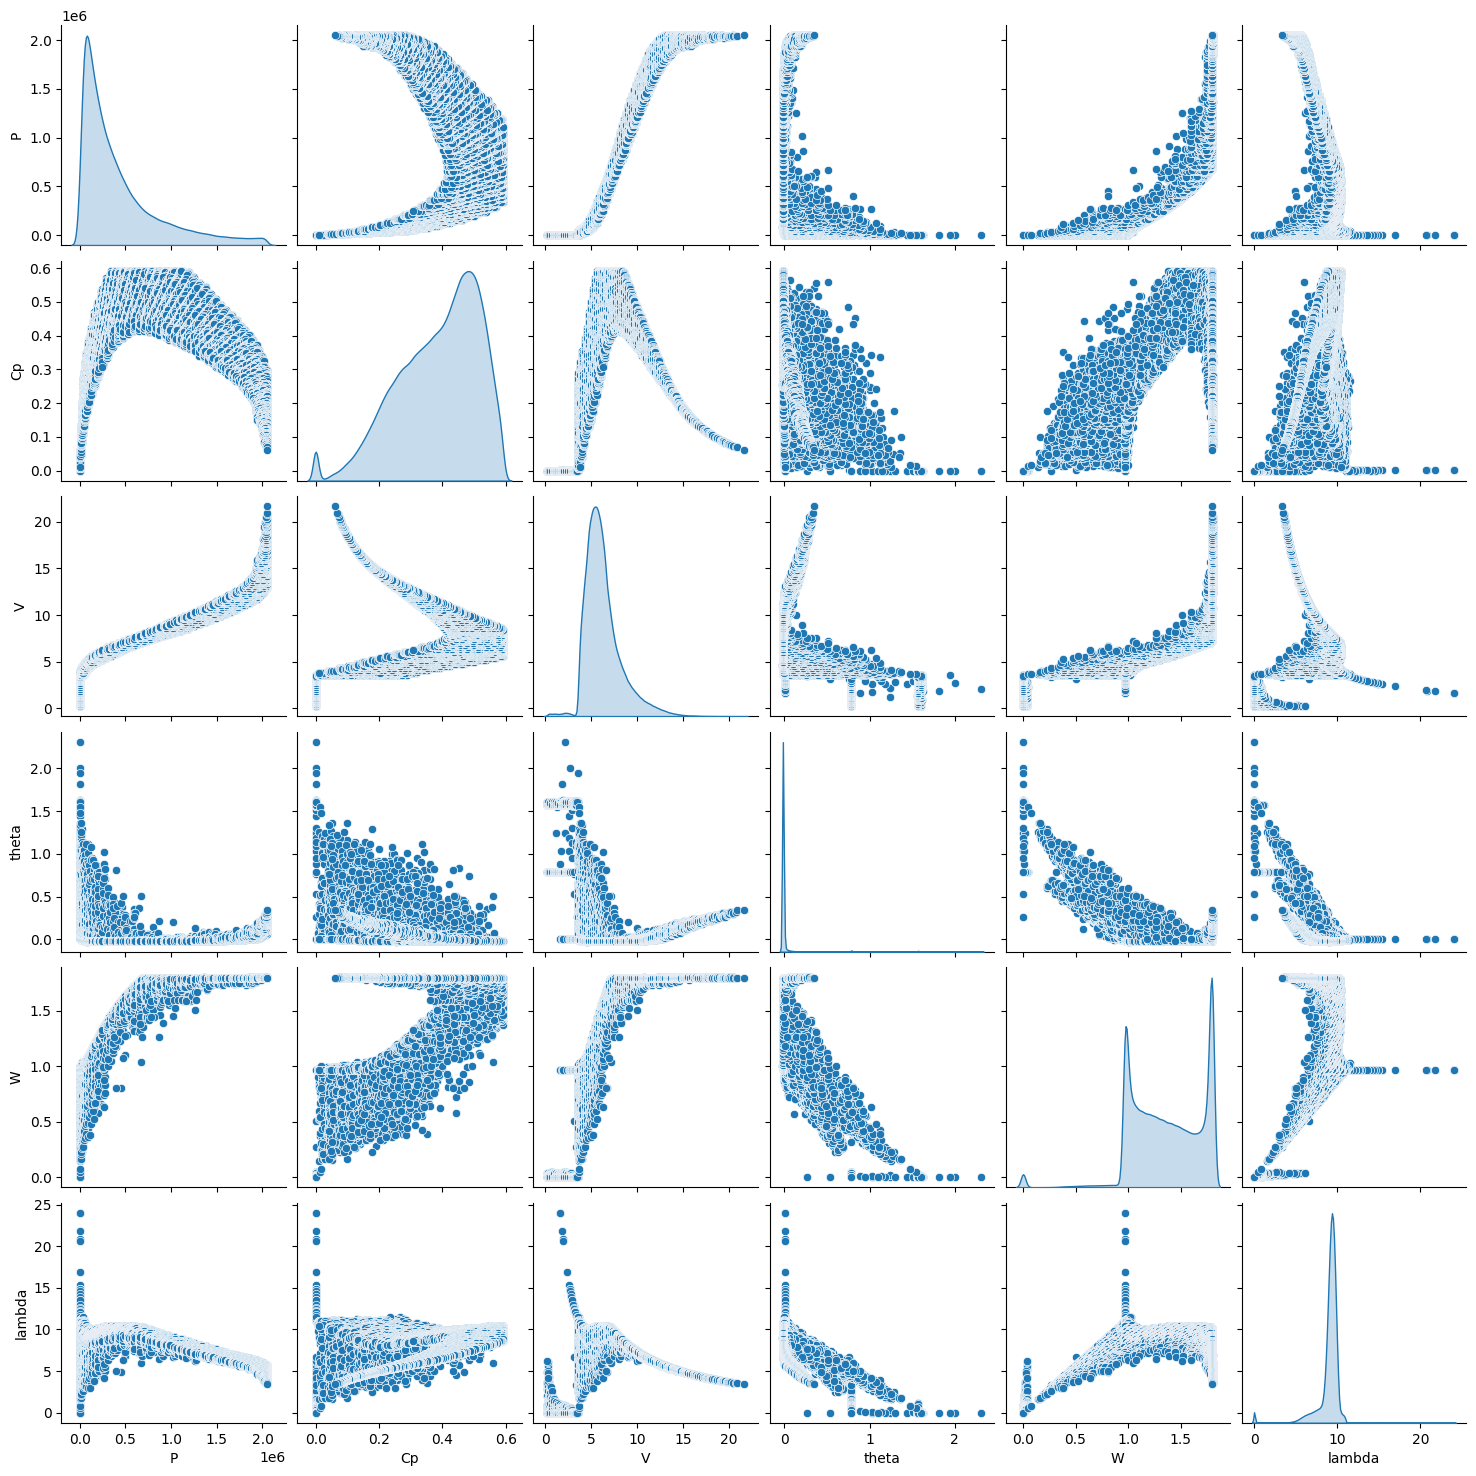

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'Cp', 'V', 'theta', 'W', 'lambda']], diag_kind='kde')

In [7]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,727292.0,6.281493,1.995660,0.230000,4.960000,5.870000,7.090000,2.167000e+01
theta,727292.0,0.002826,0.129452,-0.026704,-0.017453,-0.017279,-0.015708,2.312212e+00
W,727292.0,1.356542,0.329573,0.000000,1.089085,1.346696,1.660855,1.803274e+00
T,727292.0,2619.547843,2241.645819,0.000000,1043.010000,1963.324950,3376.169900,1.087570e+04
P,727292.0,439958.330594,442728.758322,0.000000,121400.000000,281620.000000,596549.992500,2.051870e+06
Cp,727292.0,0.385342,0.126188,0.000000,0.297588,0.407155,0.486534,5.925997e-01
lambda,727292.0,8.981742,1.298262,0.000000,8.852759,9.268851,9.602860,2.401763e+01


In [8]:
# Normalization. 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
train_dataset_norm = train_dataset.copy()
test_dataset_norm = test_dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        train_dataset_norm[col]=(train_dataset[col]-x_mean[icol])/x_std[icol]
        test_dataset_norm[col]=(test_dataset[col]-x_mean[icol])/x_std[icol]
    else: # Cp in [0,1]
        train_dataset_norm[col]=train_dataset[col]/Cp_max
        test_dataset_norm[col]=test_dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                 mean            std
V            6.281493       1.995660
theta        0.002826       0.129452
W            1.356542       0.329573
T         2619.547843    2241.645819
P       439958.330594  442728.758322
Cp           0.385342       0.126188
lambda       8.981742       1.298262

Normalized dataset
            mean       std
V      -0.000640  0.999263
theta   0.000388  1.002014
W      -0.000354  1.000317
T      -0.000550  0.999262
P      -0.000558  0.999264
Cp      0.650263  0.212993
lambda -0.000025  1.001158


In [9]:
# Split input features from labels/targets

train_dataset_copy = train_dataset_norm.copy()
test_dataset_copy = test_dataset_norm.copy()

train_features = train_dataset_copy[['V','theta','W']]
test_features = test_dataset_copy[['V','theta','W']]

train_labels = train_dataset_copy.pop('Cp')
test_labels = test_dataset_copy.pop('Cp')

print(train_features.shape)
print(train_labels.shape)

(581834, 3)
(581834,)


In [10]:
# Define the hypermodel to optimize hyperparameters
 
def model_builder(hp):
  
  input = tf.keras.Input(shape=(3,))
  #input = tf.keras.Input(shape=(2,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1,activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [11]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Cp3D_constrained')

INFO:tensorflow:Reloading Tuner from ./Hypertuning/Cp3D_constrained/tuner0.json


In [12]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#x = train_features[['V','theta','W']]
x = train_features  # input features are lambda and theta
# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
batch_size = 128
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 2
n_units: 128
learning_rate: 0.001
activation_function: relu



In [13]:
# Define single model

n_layers = 2
n_units = 128
learning_rate = 0.001
activation_function = 'relu'

input = tf.keras.Input(shape=(3,))
model = keras.Sequential()
model.add(input)

for i in range(n_layers):    
    model.add(keras.layers.Dense(units=n_units, activation=activation_function))
#model.add(keras.layers.Dense(1))
model.add(edl.layers.DenseNormalGamma(1))

model.summary() 

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#              loss='mean_absolute_error') 

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=EvidentialRegressionLoss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_normal_gamma (DenseNo  (None, 4)                516       
 rmalGamma)                                                      
                                                                 
Total params: 17,540
Trainable params: 17,540
Non-trainable params: 0
_________________________________________________________________


2023-05-07 14:18:40.234855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 14:18:40.294565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-07 14:18:40.294604: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-07 14:18:40.296590: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [14]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-8)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
#model = tuner.hypermodel.build(best_hps)
history = model.fit(x, train_labels, epochs=200, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/200
3637/3637 [==============================] - 5s 1ms/step - loss: -1.9554 - val_loss: -2.0296 - lr: 0.0010
Epoch 2/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.0645 - val_loss: -2.1105 - lr: 0.0010
Epoch 3/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.0871 - val_loss: -2.0886 - lr: 0.0010
Epoch 4/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.1038 - val_loss: -2.1114 - lr: 0.0010
Epoch 5/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.1140 - val_loss: -2.1426 - lr: 0.0010
Epoch 6/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.1271 - val_loss: -2.1314 - lr: 0.0010
Epoch 7/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.1345 - val_loss: -2.1708 - lr: 0.0010
Epoch 8/200
3637/3637 [==============================] - 4s 1ms/step - loss: -2.1390 - val_loss: -2.1542 - lr: 0.0010
Epoch 9/200
3637/3637 [==============================] -

Best epoch: 197


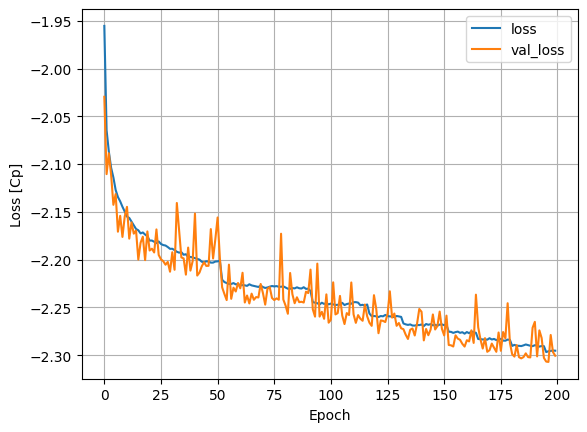

In [15]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cp]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x, train_labels, epochs=best_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr]) """


In [26]:
# save model weights 
#model.save_weights('./Models/Cp_model_weights.hdf5')

# load model weights
#model.load_weights('./Models/Cp_model_weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('../../Models/Cp3D_constrained_model.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

In [11]:
# load model 

#model = tf.keras.models.load_model('../../Models/Cp3D_constrained_model.h5')
#model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               512       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________


2023-05-04 13:43:37.328491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 13:43:37.355592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-04 13:43:37.355611: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-04 13:43:37.356419: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [16]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

(145458, 3)
(145458, 4)
(145458,)


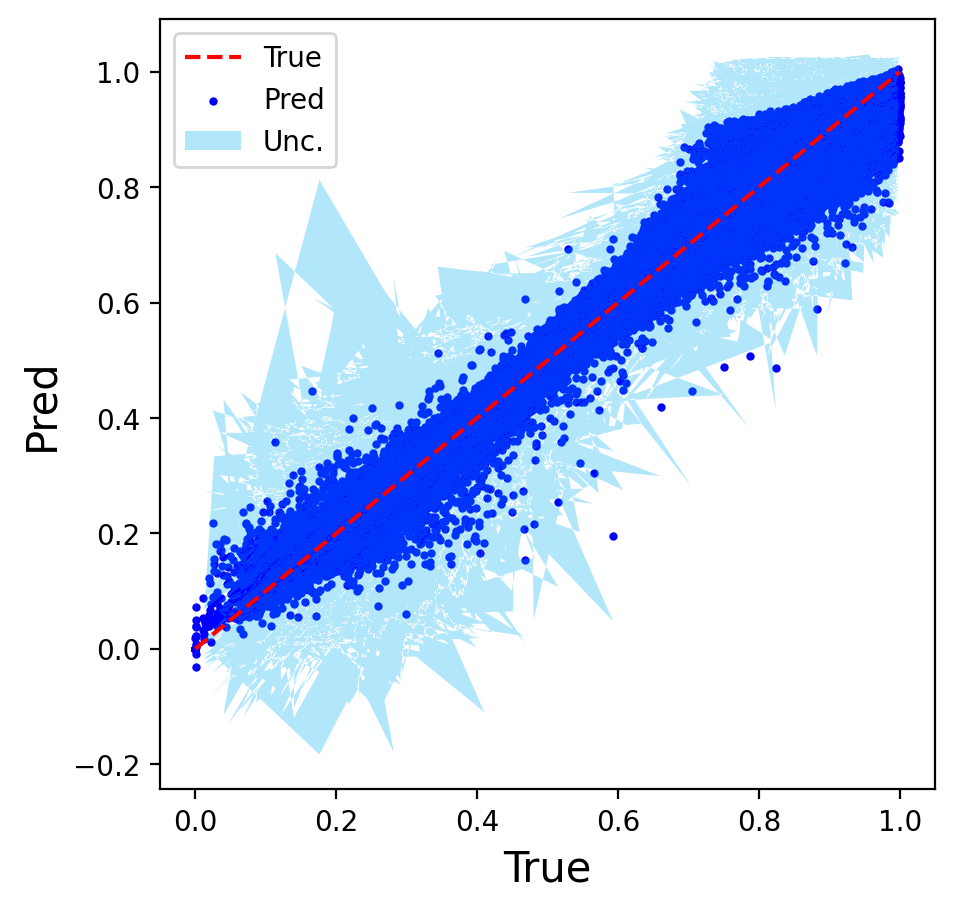

Test MAE: 0.022659821983625122


In [17]:
# Evaluate the model on Cp data

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

print(x_test.shape)
print(y_pred.shape)
print(y_true.shape)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred[:,0])
print("Test MAE: "+str(test_mae))

(727292,)
0.38509065
(727292,)
0.3853415261667347


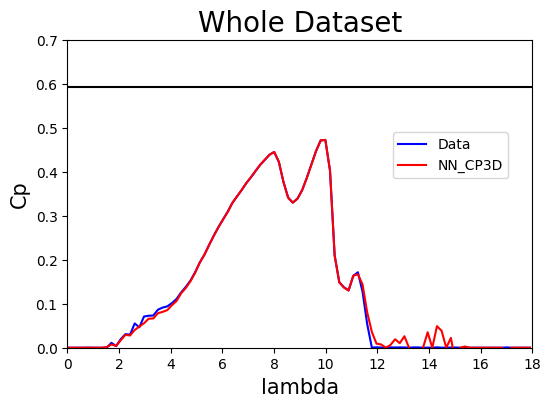

In [18]:
# Plot Cp vs lambda, averaging theta and W variable

# Prediction of Cp
x_norm = np.zeros((len(dataset['lambda']),3))
x_V = (dataset['V'] - dataset['V'].mean()) / dataset['V'].std()
x_theta = (dataset['theta'] - dataset['theta'].mean()) / dataset['theta'].std()
x_W = (dataset['W'] - dataset['W'].mean()) / dataset['W'].std()
x_norm[:,0] = x_V[:]
x_norm[:,1] = x_theta[:]
x_norm[:,2] = x_W[:]
Cp_norm = model.predict(x_norm)
#Cp_pred = Cp_norm * dataset['Cp'].std() + dataset['Cp'].mean()
Cp_pred = Cp_norm[:,0] * Cp_max

# Estimate the Cp curve with the median
lmin = 0
lmax = 18
nbins = 100
Cp_estimated = np.zeros(nbins)
Cp_estimated_NN = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

print(Cp_pred.shape)
print(np.mean(Cp_pred))
print(Cp_data.shape)
print(np.mean(Cp_data))

#Cp_predicted = np.zeros(nbins)

for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_data) & (lambd_data<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_data[l_subset]     # Cp distribution of bin i
    Cpi_NN = Cp_pred[l_subset]  # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated[i]=statistics.mean(Cpi)
        Cp_estimated_NN[i]=statistics.mean(Cpi_NN)

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'b-',label='Data')
plt.plot(lambd_estimated, Cp_estimated_NN, 'r-',label='NN_CP3D')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,18])
plt.ylim([0,0.7])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()

In [39]:
def plot_PredvsTrue_error(y_true, y_pred, error, n_stds=2):

    #mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    #mu = mu[:, 0]
    #var = np.sqrt(beta / (v * (alpha - 1)))
    mu = y_pred
    var = error
    #var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

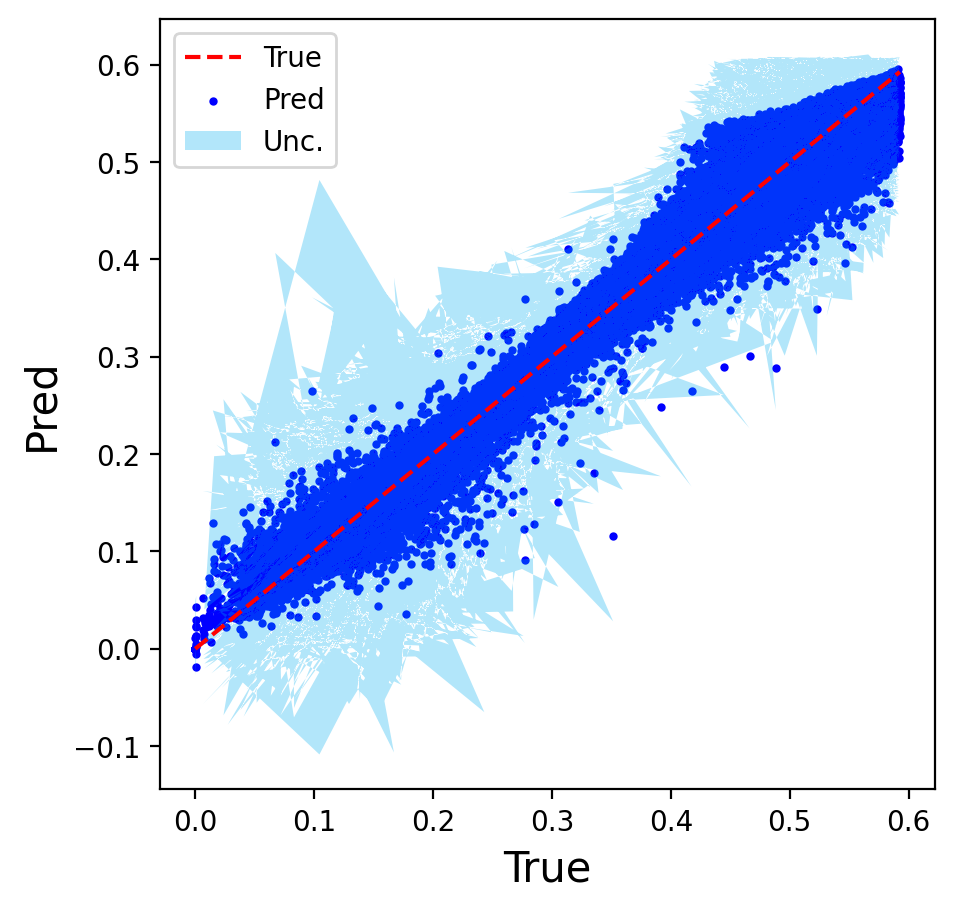


Test MAE: 0.013428210441467732
Test RMSE: 0.018344686322015694
Test MAPE: 4.3529295284319955 %
Test R2: 0.9788237485902874


In [41]:
# Evaluate Cp on original units

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
mu = mu[:, 0]
error_pred = np.sqrt(beta / (v * (alpha - 1)))

y_pred = y_pred[:,0]
error_pred = error_pred[:,0]
y_pred = y_pred * Cp_max
y_true = y_true * Cp_max
error_pred = error_pred * Cp_max # propagation of error

#print(x_test.shape)
#print(y_pred.shape)
#print(y_true.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, error_pred)

y_pred_nonzero = y_pred[abs(y_true)>0]
y_true_nonzero = y_true[abs(y_true)>0]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

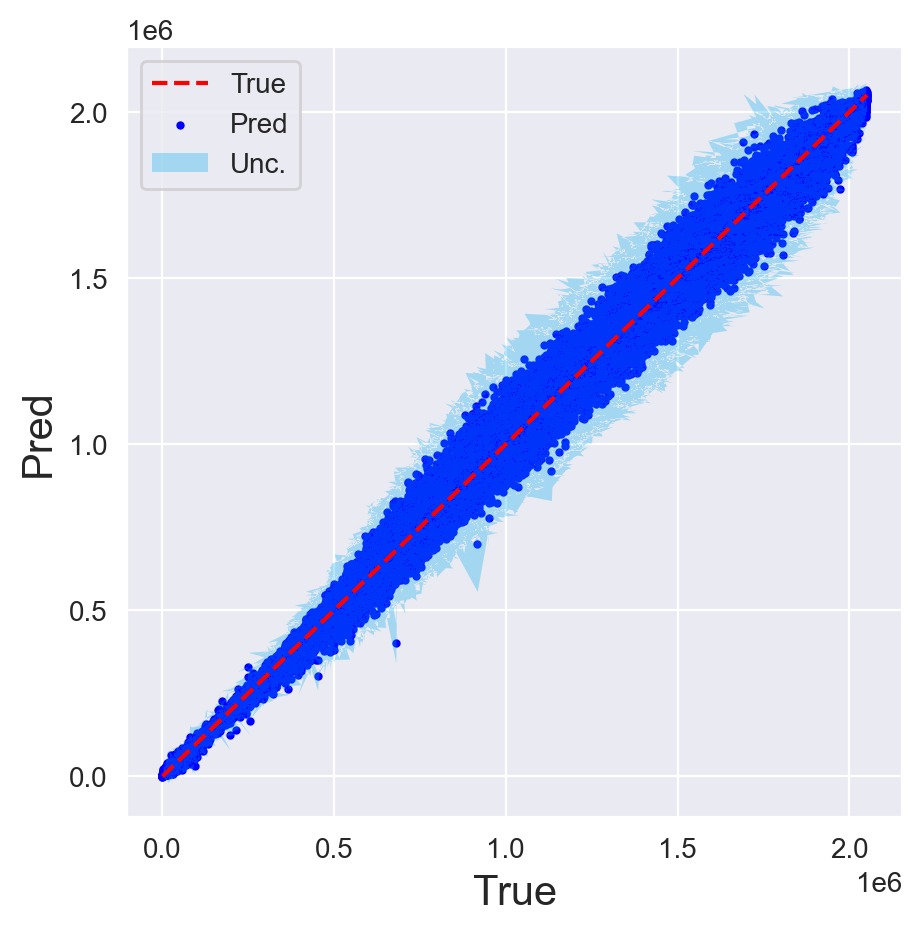


Test MAE: 15080.712229966512
Test RMSE: 27188.074117752676
Test MAPE: 3.5786495781338967 %
Test R2: 0.9962508428806469


In [67]:
# Evaluate P from Cp

def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
Cp_pred = model(x_test)
Cp_true = np.array(test_labels)

mu, v, alpha, beta = tf.split(Cp_pred, 4, axis=-1)
mu = mu[:, 0]
error_pred = np.sqrt(beta / (v * (alpha - 1)))

Cp_pred = Cp_pred[:,0]
error_pred = error_pred[:,0]
Cp_pred = Cp_pred * Cp_max
Cp_true = Cp_true * Cp_max
error_pred = error_pred * Cp_max # propagation of error

V_true = test_dataset.loc[:,'V']
V_true = V_true.to_numpy()
P_true = test_dataset.loc[:,'P']
P_true = P_true.to_numpy()
P_pred = P_fromCp(Cp_pred,V_true)

#print(error_pred.shape)
#print(V_true.shape)
error_pred[:] = error_pred[:] * 0.5 * const.rho * const.A * V_true[:]**3 # propagate error from Cp to P

y_true = P_true
y_pred = P_pred

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, error_pred)

# Metrics
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

Mean Absolute Error: 15080.712
Mean Absolute Uncertainty: 17610.04


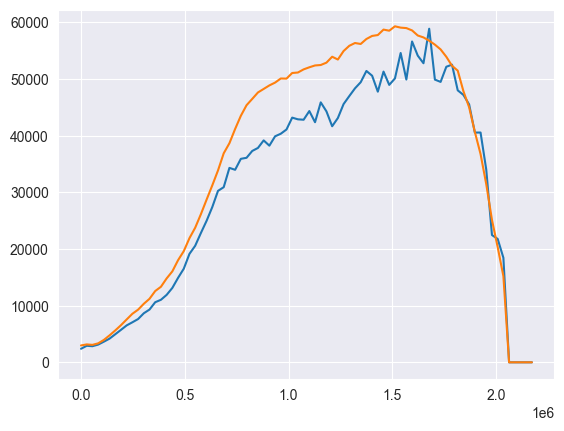

In [68]:
# Mean uncertainty. True error vs Power. Uncertainty vs Power

#print(P_pred.shape)
#print(error_pred.shape)
error_true = np.abs(P_pred-P_true)
print('Mean Absolute Error: '+str(np.mean(error_true)))
print('Mean Absolute Uncertainty: '+str(np.mean(error_pred)))

nbins = 80
Pmax = 2200*1e3
Pmin = 0
dP = (Pmax-Pmin)/nbins
error_histo = np.zeros(nbins)
uncertainty_histo = np.zeros(nbins)
n_histo = np.zeros(nbins)
for i in range(len(P_pred)):
    #j = int(P_pred[i]/dP)
    j = int(P_true[i]/dP)
    error_histo[j] = error_histo[j] + error_true[i]
    uncertainty_histo[j] = uncertainty_histo[j] + error_pred[i]
    n_histo[j] = n_histo[j]+1

for j in range(nbins):
    if(n_histo[j]>0):
        error_histo[j] = error_histo[j]/n_histo[j]    
        uncertainty_histo[j] = uncertainty_histo[j]/n_histo[j]    
P_array = np.arange(Pmin+0.5,Pmax-0.5,dP)

# True error vs Power
plt.plot(P_array,error_histo)

# Uncertainty vs Power
plt.plot(P_array,uncertainty_histo)
